#  Demo: HeartSoundPreprocessor

Notebook này demo từng bước xử lý trong `data_preprocessing.py`

##  Nội dung:
1.  Khởi tạo HeartSoundPreprocessor
2.  Load và visualize 1 file WAV
3.  Apply Butterworth filter
4.  Extract cardiac cycles từ TSV
5.  Normalize cycles
6.  Extract Scattering features
7.  Visualize toàn bộ pipeline

---

## 1. Import Libraries

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import signal as scipy_signal

# Import HeartSoundPreprocessor
sys.path.append('../src')
from data_preprocessing import HeartSoundPreprocessor

# Setup plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (15, 5)
%matplotlib inline

print(" Đã import thành công!")

 Đã import thành công!


## 2. Cấu hình Tham Số

In [2]:
# Tham số (giống 04_training_cnn_method và 05_training_lstm_method)
SR = 4000           # Sampling rate
MAX_LEN = 3000      # Độ dài cycle tối đa
CUTOFF_FREQ = 500   # Butterworth filter cutoff
J = 6               # Scattering depth

# Đường dẫn
RAW_DATA_DIR = '../data/raw/training_data/'
METADATA_FILE = '../data/raw/training_data.csv'

print(f" Cấu hình:")
print(f"   - SR = {SR} Hz")
print(f"   - MAX_LEN = {MAX_LEN} samples ({MAX_LEN/SR:.2f}s)")
print(f"   - CUTOFF_FREQ = {CUTOFF_FREQ} Hz")
print(f"   - Scattering J = {J}")
print(f"\n Data directory: {os.path.abspath(RAW_DATA_DIR)}")

 Cấu hình:
   - SR = 4000 Hz
   - MAX_LEN = 3000 samples (0.75s)
   - CUTOFF_FREQ = 500 Hz
   - Scattering J = 6

 Data directory: C:\Users\Admin\Downloads\namCuoi\new_nc\v2\VIP\data\raw\training_data


## 3. Khởi tạo HeartSoundPreprocessor

In [3]:
# Khởi tạo preprocessor
preprocessor = HeartSoundPreprocessor(
    sr=SR,
    max_len=MAX_LEN,
    cutoff_freq=CUTOFF_FREQ,
    scattering_j=J
)

print(" Đã khởi tạo HeartSoundPreprocessor!")
print(f"\n Thông tin:")
print(f"   - Sampling rate: {preprocessor.sr} Hz")
print(f"   - Max length: {preprocessor.max_len} samples")
print(f"   - Cutoff frequency: {preprocessor.cutoff_freq} Hz")
print(f"   - Scattering J: {preprocessor.scattering_j}")

 Đã khởi tạo HeartSoundPreprocessor!

 Thông tin:
   - Sampling rate: 4000 Hz
   - Max length: 3000 samples
   - Cutoff frequency: 500 Hz
   - Scattering J: 6


## 4. Tìm File Mẫu để Demo

In [4]:
# Tìm 1 file WAV và TSV để demo
wav_files = glob.glob(os.path.join(RAW_DATA_DIR, '*.wav'))

if len(wav_files) == 0:
    print(" Không tìm thấy file WAV!")
    print(f"   Kiểm tra đường dẫn: {RAW_DATA_DIR}")
else:
    # Chọn file đầu tiên
    sample_wav = wav_files[0]
    sample_tsv = sample_wav.replace('.wav', '.tsv')
    
    print(f" Tìm thấy {len(wav_files)} files WAV")
    print(f"\n File demo:")
    print(f"   WAV: {os.path.basename(sample_wav)}")
    print(f"   TSV: {os.path.basename(sample_tsv)}")
    print(f"   Exists: WAV={os.path.exists(sample_wav)}, TSV={os.path.exists(sample_tsv)}")

 Tìm thấy 3163 files WAV

 File demo:
   WAV: 13918_AV.wav
   TSV: 13918_AV.tsv
   Exists: WAV=True, TSV=True


## 5. Load Raw Signal

In [5]:
# Load signal gốc
signal_raw, sr_original = librosa.load(sample_wav, sr=SR)

print(f" Thông tin signal:")
print(f"   - Duration: {len(signal_raw)/SR:.2f}s")
print(f"   - Samples: {len(signal_raw):,}")
print(f"   - Sampling rate: {SR} Hz")
print(f"   - Min: {signal_raw.min():.4f}")
print(f"   - Max: {signal_raw.max():.4f}")
print(f"   - Mean: {signal_raw.mean():.4f}")
print(f"   - Std: {signal_raw.std():.4f}")

 Thông tin signal:
   - Duration: 10.29s
   - Samples: 41,152
   - Sampling rate: 4000 Hz
   - Min: -1.0000
   - Max: 1.0000
   - Mean: 0.0004
   - Std: 0.0515


### 5.1. Visualize Raw Signal

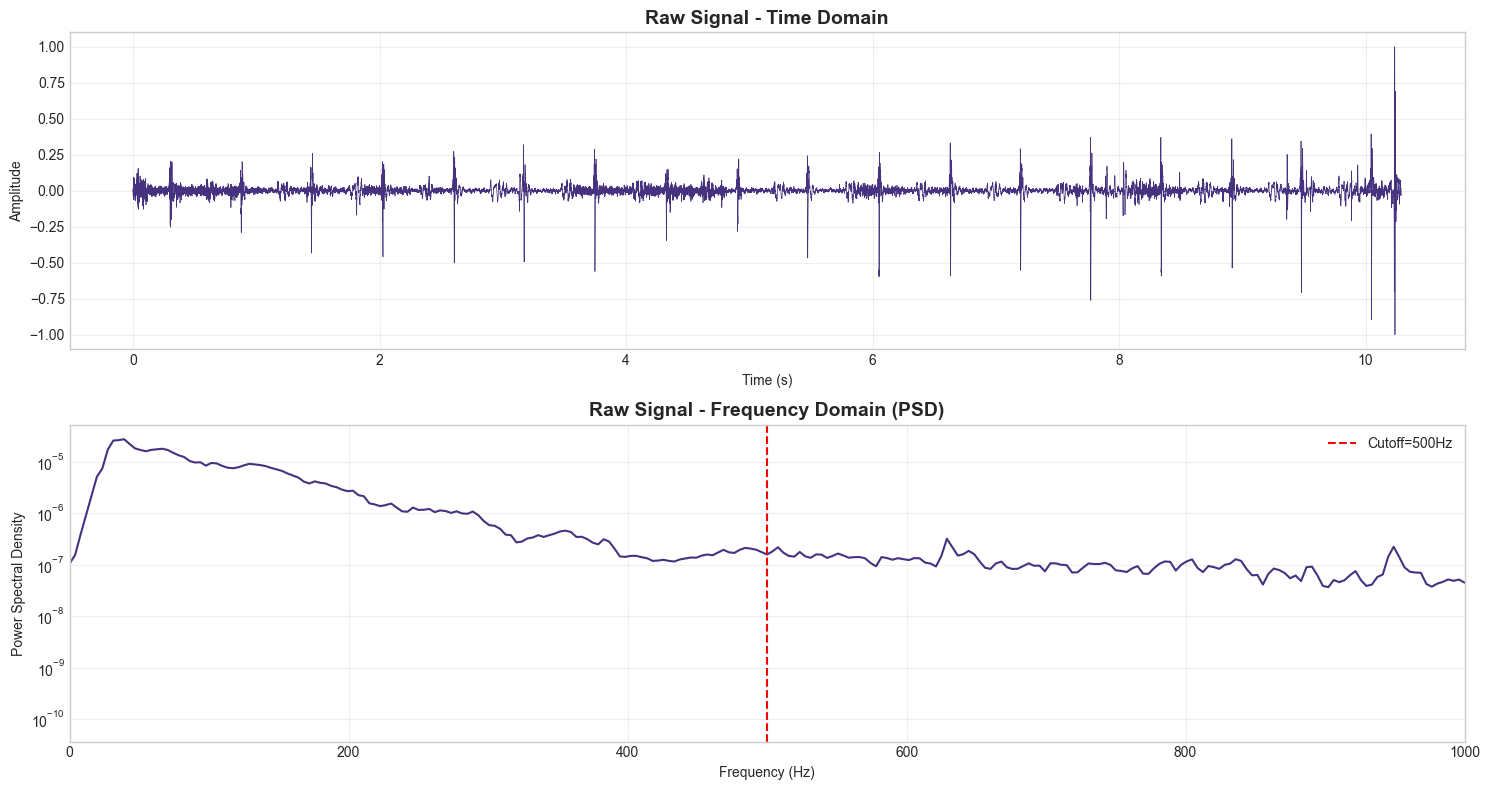

 Đã visualize raw signal!


In [6]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Time domain
time = np.arange(len(signal_raw)) / SR
axes[0].plot(time, signal_raw, linewidth=0.5)
axes[0].set_title('Raw Signal - Time Domain', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Frequency domain
freqs, psd = scipy_signal.welch(signal_raw, SR, nperseg=1024)
axes[1].semilogy(freqs, psd)
axes[1].set_title('Raw Signal - Frequency Domain (PSD)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density')
axes[1].set_xlim([0, 1000])
axes[1].grid(True, alpha=0.3)
axes[1].axvline(CUTOFF_FREQ, color='r', linestyle='--', label=f'Cutoff={CUTOFF_FREQ}Hz')
axes[1].legend()

plt.tight_layout()
plt.show()

print(" Đã visualize raw signal!")

## 6. Apply Butterworth Low-Pass Filter

In [7]:
# Apply Butterworth filter
signal_filtered = preprocessor.butter_lowpass_filter(signal_raw, order=5)

print(f" Đã apply Butterworth filter (cutoff={CUTOFF_FREQ}Hz)")
print(f"\n So sánh:")
print(f"   Raw    - Min: {signal_raw.min():.4f}, Max: {signal_raw.max():.4f}")
print(f"   Filtered - Min: {signal_filtered.min():.4f}, Max: {signal_filtered.max():.4f}")

 Đã apply Butterworth filter (cutoff=500Hz)

 So sánh:
   Raw    - Min: -1.0000, Max: 1.0000
   Filtered - Min: -1.0330, Max: 1.1026


### 6.1. So Sánh Raw vs Filtered

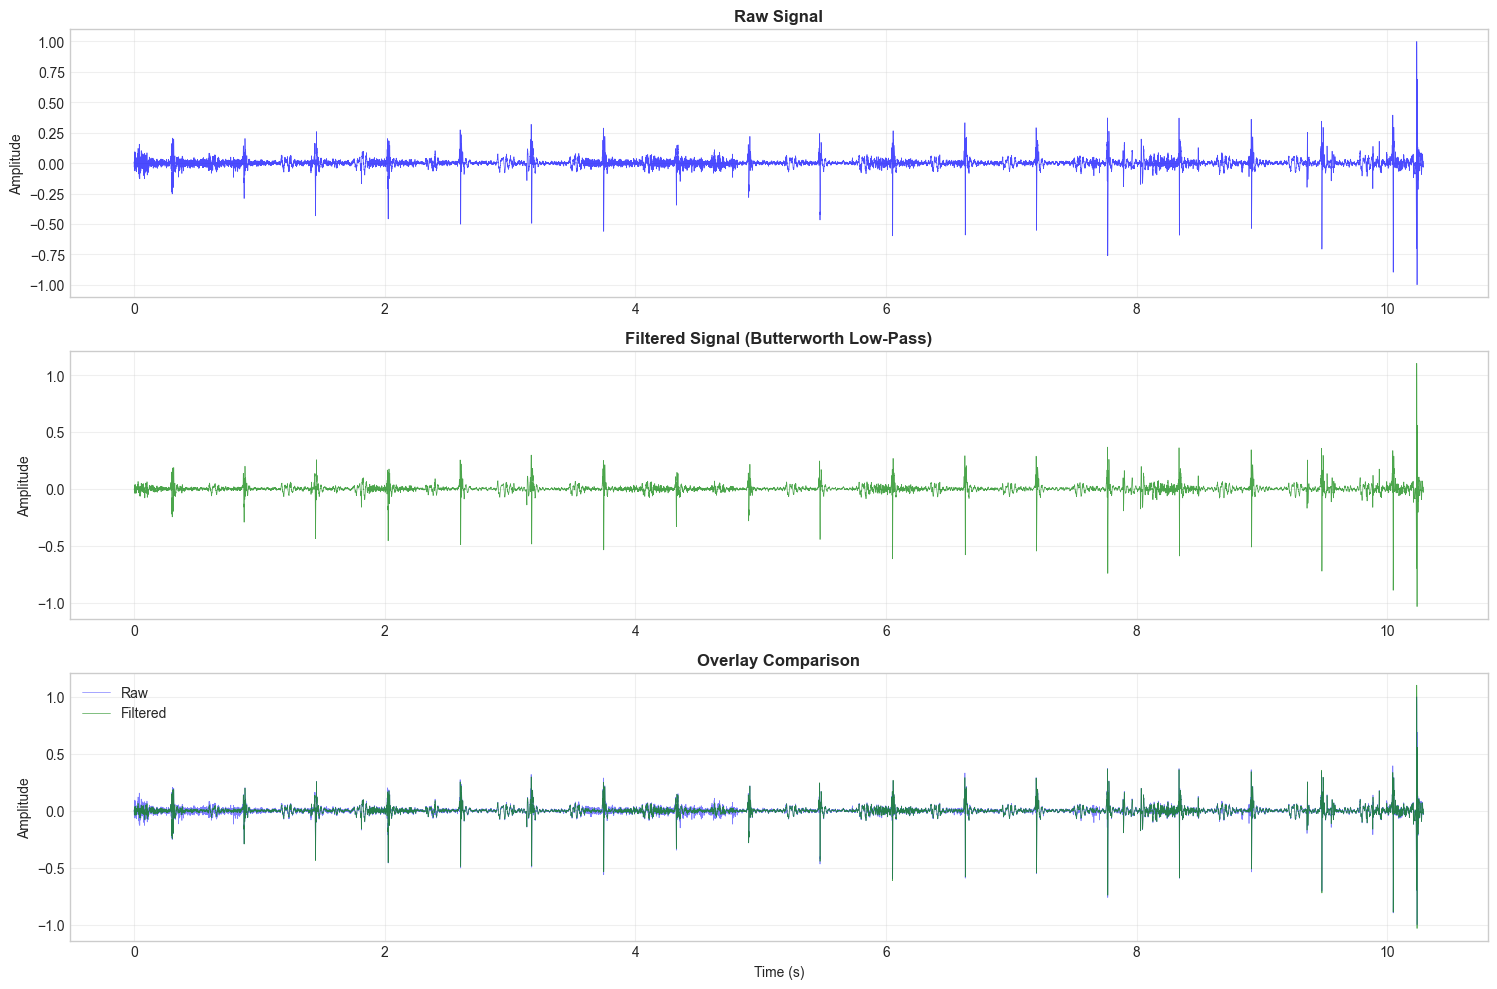

 Filter đã loại bỏ high-frequency noise!


In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Raw
axes[0].plot(time, signal_raw, linewidth=0.5, color='blue', alpha=0.7)
axes[0].set_title('Raw Signal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Filtered
axes[1].plot(time, signal_filtered, linewidth=0.5, color='green', alpha=0.7)
axes[1].set_title('Filtered Signal (Butterworth Low-Pass)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

# Overlay
axes[2].plot(time, signal_raw, linewidth=0.5, color='blue', alpha=0.5, label='Raw')
axes[2].plot(time, signal_filtered, linewidth=0.5, color='green', alpha=0.7, label='Filtered')
axes[2].set_title('Overlay Comparison', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Filter đã loại bỏ high-frequency noise!")

## 7. Extract Cardiac Cycles từ TSV

In [9]:
# Extract cycles
cycles = preprocessor.extract_cycles(sample_wav, sample_tsv)

print(f" Đã extract {len(cycles)} cardiac cycles")

if len(cycles) > 0:
    cycle_lengths = [len(c) for c in cycles]
    print(f"\n Thống kê độ dài cycles:")
    print(f"   - Min: {min(cycle_lengths)} samples ({min(cycle_lengths)/SR:.3f}s)")
    print(f"   - Max: {max(cycle_lengths)} samples ({max(cycle_lengths)/SR:.3f}s)")
    print(f"   - Mean: {np.mean(cycle_lengths):.0f} samples ({np.mean(cycle_lengths)/SR:.3f}s)")
    print(f"   - Median: {np.median(cycle_lengths):.0f} samples ({np.median(cycle_lengths)/SR:.3f}s)")
else:
    print(" Không extract được cycles!")

 Đã extract 14 cardiac cycles

 Thống kê độ dài cycles:
   - Min: 2103 samples (0.526s)
   - Max: 2532 samples (0.633s)
   - Mean: 2300 samples (0.575s)
   - Median: 2299 samples (0.575s)


### 7.1. Visualize Extracted Cycles

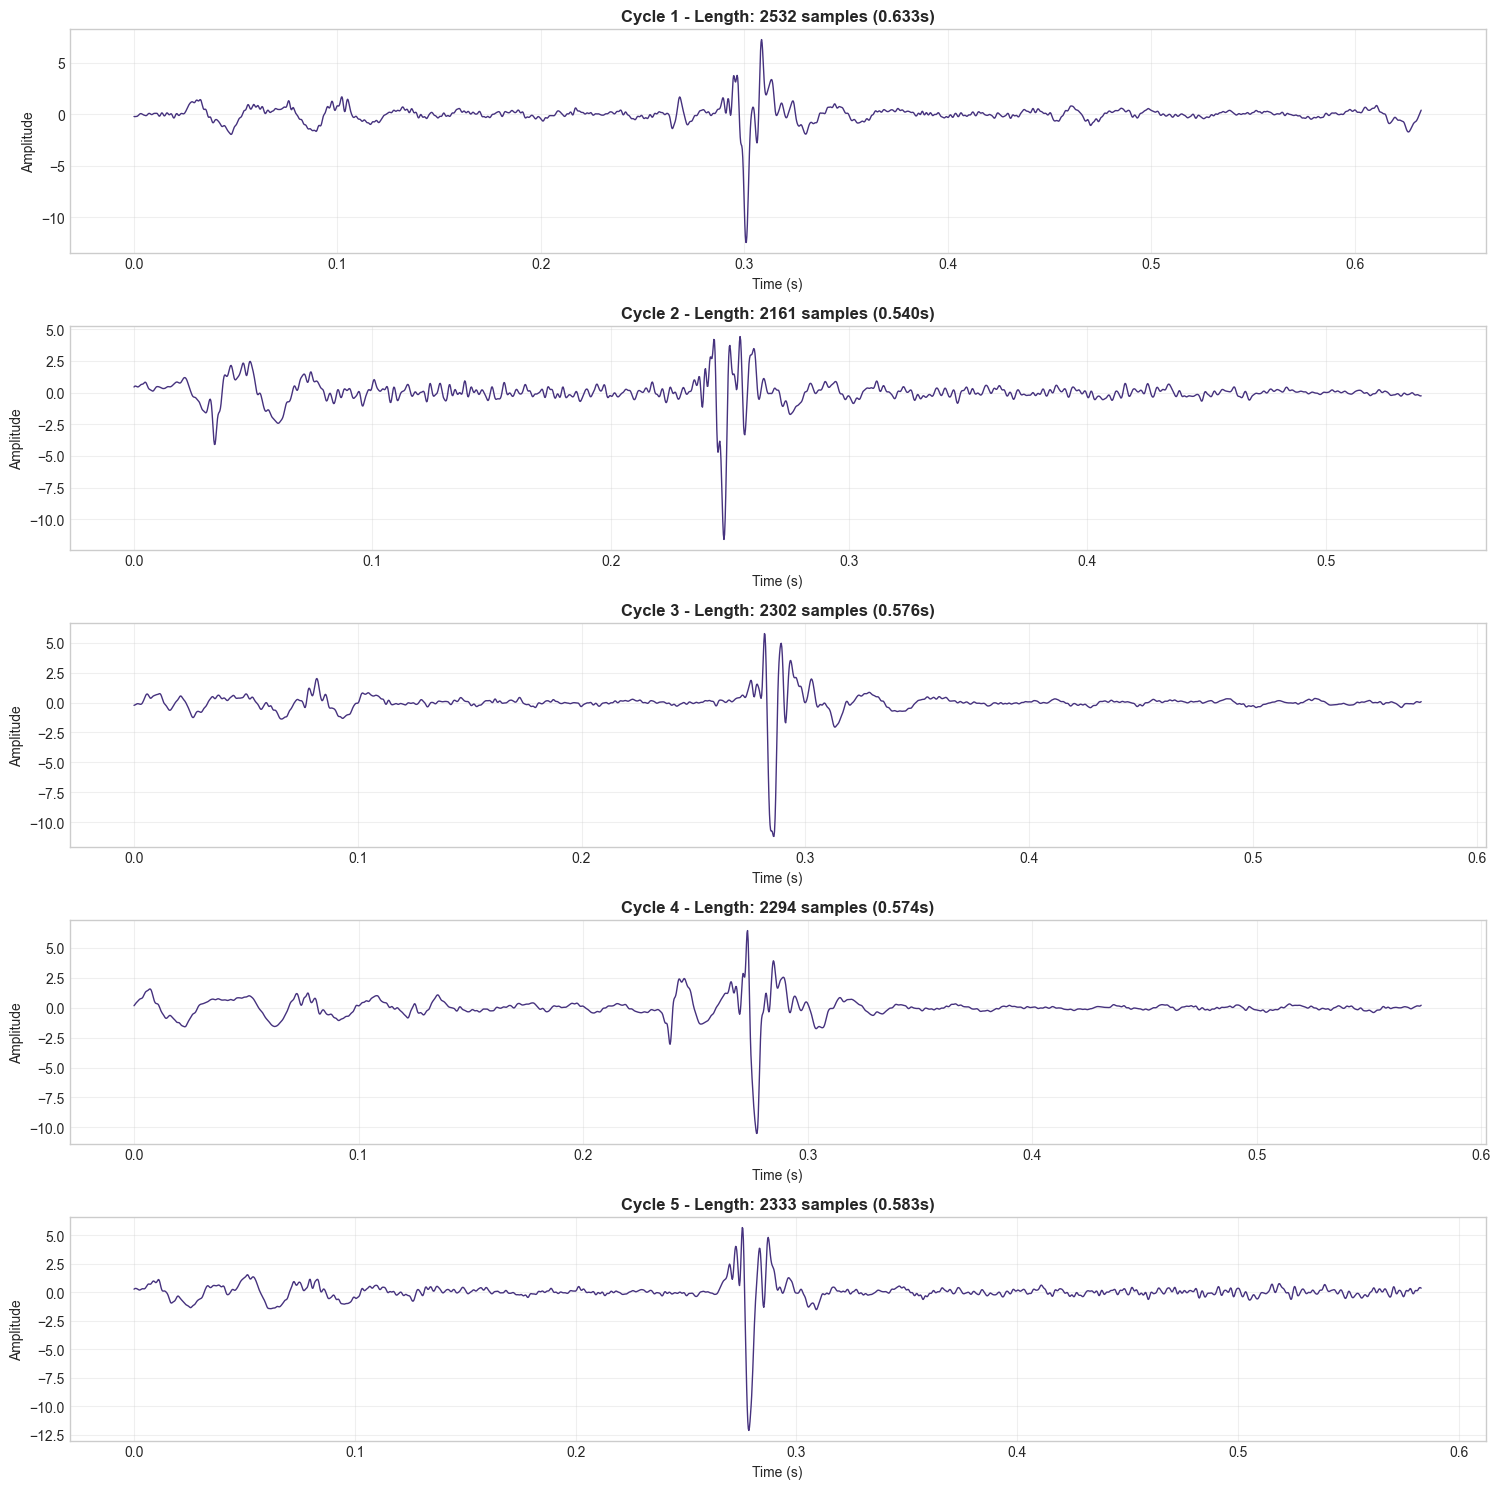

 Đã visualize 5 cycles đầu tiên!


In [10]:
if len(cycles) > 0:
    # Hiển thị 5 cycles đầu tiên
    n_show = min(5, len(cycles))
    
    fig, axes = plt.subplots(n_show, 1, figsize=(15, 3*n_show))
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        cycle = cycles[i]
        time_cycle = np.arange(len(cycle)) / SR
        
        axes[i].plot(time_cycle, cycle, linewidth=1)
        axes[i].set_title(f'Cycle {i+1} - Length: {len(cycle)} samples ({len(cycle)/SR:.3f}s)', 
                         fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f" Đã visualize {n_show} cycles đầu tiên!")
else:
    print(" Không có cycles để visualize!")

## 8. Normalize Signal

 So sánh trước/sau normalize:
   Raw        - Mean: -0.0000, Std: 1.0000
   Normalized - Mean: -0.0000, Std: 1.0000


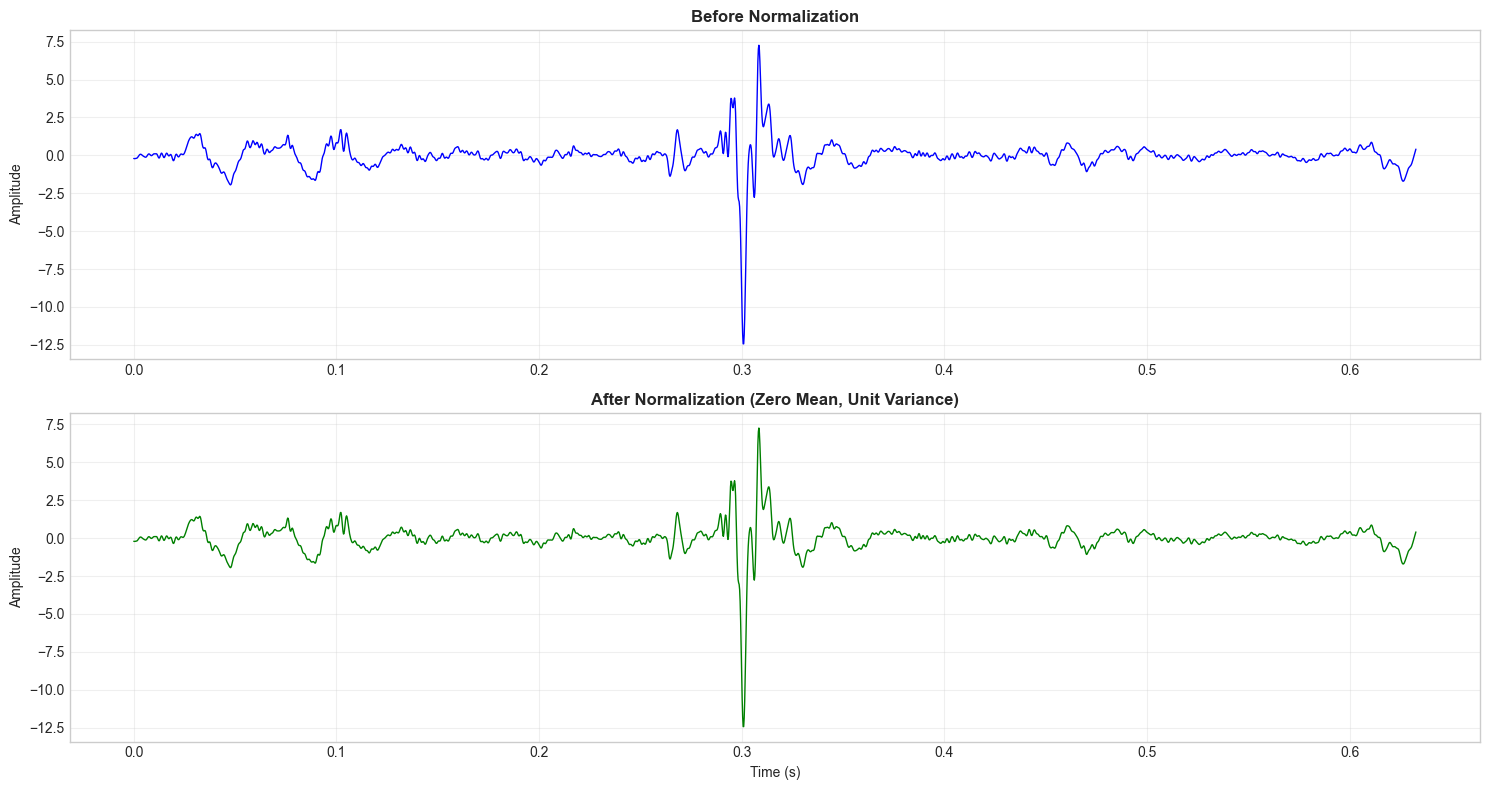

 Normalization đưa signal về mean=0, std=1!


In [11]:
if len(cycles) > 0:
    # Lấy 1 cycle để demo
    cycle_raw = cycles[0]
    
    # Normalize
    cycle_normalized = preprocessor.normalize_signal(cycle_raw)
    
    print(f" So sánh trước/sau normalize:")
    print(f"   Raw        - Mean: {cycle_raw.mean():.4f}, Std: {cycle_raw.std():.4f}")
    print(f"   Normalized - Mean: {cycle_normalized.mean():.4f}, Std: {cycle_normalized.std():.4f}")
    
    # Visualize
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    
    time_cycle = np.arange(len(cycle_raw)) / SR
    
    axes[0].plot(time_cycle, cycle_raw, linewidth=1, color='blue')
    axes[0].set_title('Before Normalization', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(time_cycle, cycle_normalized, linewidth=1, color='green')
    axes[1].set_title('After Normalization (Zero Mean, Unit Variance)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(" Normalization đưa signal về mean=0, std=1!")
else:
    print(" Không có cycles để normalize!")

## 9. Extract Scattering Features

In [12]:
if len(cycles) > 0:
    # Extract scattering features từ cycle đầu tiên
    cycle = cycles[0]
    features = preprocessor.extract_scattering_features(cycle)
    
    print(f" Scattering Features:")
    print(f"   - Input shape: {cycle.shape}")
    print(f"   - Output shape: {features.shape}")
    print(f"   - Feature dimension: {features.shape[0] * features.shape[1]}")
    print(f"   - Min: {features.min():.4f}")
    print(f"   - Max: {features.max():.4f}")
    print(f"   - Mean: {features.mean():.4f}")
else:
    print(" Không có cycles để extract features!")

 Scattering Features:
   - Input shape: (2532,)
   - Output shape: (26, 47)
   - Feature dimension: 1222
   - Min: -0.1240
   - Max: 0.3556
   - Mean: 0.0108


### 9.1. Visualize Scattering Features

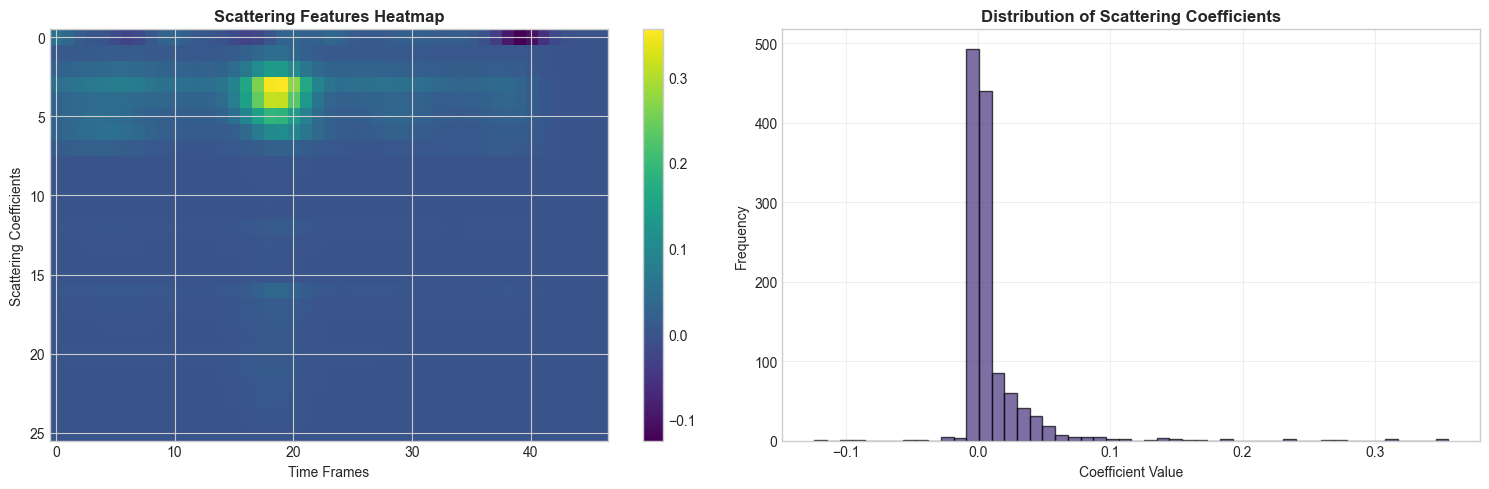

 Scattering features capture multi-scale time-frequency information!


In [13]:
if len(cycles) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Heatmap
    im = axes[0].imshow(features, aspect='auto', cmap='viridis', interpolation='nearest')
    axes[0].set_title('Scattering Features Heatmap', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Time Frames')
    axes[0].set_ylabel('Scattering Coefficients')
    plt.colorbar(im, ax=axes[0])
    
    # Flatten và histogram
    features_flat = features.flatten()
    axes[1].hist(features_flat, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title('Distribution of Scattering Coefficients', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Coefficient Value')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(" Scattering features capture multi-scale time-frequency information!")
else:
    print(" Không có features để visualize!")

## 10. Tóm Tắt Pipeline

### Workflow đã demo:
```
Raw WAV File (4000 Hz)
    ↓
Butterworth Low-Pass Filter (500 Hz cutoff)
    ↓
Extract Cardiac Cycles (TSV annotations: 1→2→3→4)
    ↓
Normalize Each Cycle (Zero mean, Unit variance)
    ↓
Pad/Crop to MAX_LEN (3000 samples)
    ↓
Scattering Transform (J=6, Q=8)
    ↓
Features Ready for Training!
```

### Key Points:
-  **Butterworth filter** loại bỏ high-frequency noise
-  **Cycle extraction** tận dụng TSV annotations
-  **Normalization** standardize amplitude
-  **Scattering** extract multi-scale features
-  **Fixed length** (3000 samples) cho CNN/LSTM

---

** Demo hoàn tất!**